In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

In [3]:
csv_file_path = "./tutorial.csv"
df = pd.read_csv(csv_file_path, sep=';')

products = np.unique(df['product'])
print(products)

data = {}

for product in products:
    data[product] = df[df['product'] == product]

['AMETHYSTS' 'STARFRUIT']


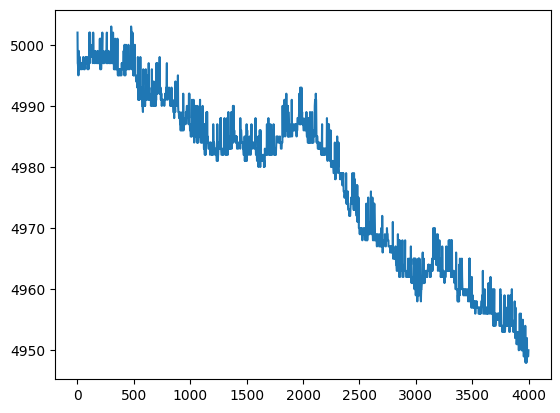

In [4]:
plt.plot(data[products[1]]['bid_price_1'])

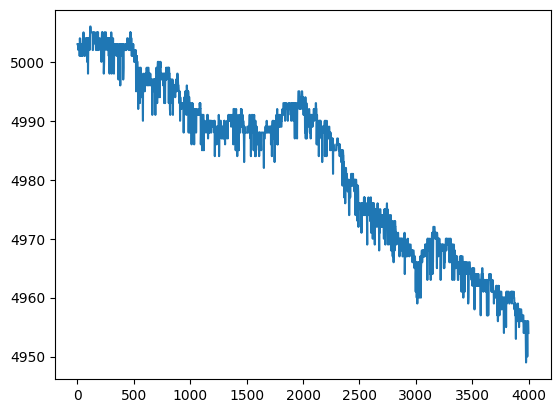

In [82]:
plt.plot(data[products[1]]['ask_price_1'])

In [83]:
data[products[1]].head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
1,-2,0,STARFRUIT,5002,1,4997.0,31.0,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,5002.5,0.00000
3,-2,100,STARFRUIT,4997,24,NaN,NaN,NaN,NaN,5003,2,5004.0,22.0,NaN,NaN,5000.0,0.00000
4,-2,200,STARFRUIT,4997,2,4996.0,20.0,NaN,NaN,5003,20,NaN,NaN,NaN,NaN,5000.0,0.00000
7,-2,300,STARFRUIT,4996,31,NaN,NaN,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,4999.5,-72.00000
9,-2,400,STARFRUIT,4995,27,NaN,NaN,NaN,NaN,5002,27,NaN,NaN,NaN,NaN,4998.5,-52.53125


In [84]:
def get_df(file_path, prod_index):
    df = pd.read_csv(file_path, sep=';')
    products = np.unique(df['product'])
    data = {}
    for product in products:
        data[product] = df[df['product'] == product]
    df_prod1 = pd.DataFrame()
    df_prod1['date'] = data[products[prod_index]]['day'].astype(float)
    df_prod1['time'] = data[products[prod_index]]['timestamp'].astype(float)
    df_prod1['bid'] = data[products[prod_index]]['bid_price_1'].astype(float)
    df_prod1['bs'] = data[products[prod_index]]['bid_volume_1'].astype(float)
    df_prod1['ask'] = data[products[prod_index]]['ask_price_1'].astype(float)
    df_prod1['as'] = data[products[prod_index]]['ask_volume_1'].astype(float)
    df_prod1['mid'] = (df_prod1['bid'] + df_prod1['ask']) / 2
    df_prod1['imb']=df_prod1['bs'].astype(float)/(df_prod1['bs'].astype(float)+df_prod1['as'].astype(float))
    df_prod1['wmid']=df_prod1['ask'].astype(float)*df_prod1['imb']+df_prod1['bid'].astype(float)*(1-df_prod1['imb'])
    return df_prod1

In [85]:
get_df(csv_file_path, 1)

,date,time,bid,bs,ask,as,mid,imb,wmid
1,-2.0,0.0,5002.0,1.0,5003.0,31.0,5002.5,0.031250,5002.031250
3,-2.0,100.0,4997.0,24.0,5003.0,2.0,5000.0,0.923077,5002.538462
4,-2.0,200.0,4997.0,2.0,5003.0,20.0,5000.0,0.090909,4997.545455
7,-2.0,300.0,4996.0,31.0,5003.0,31.0,4999.5,0.500000,4999.500000
9,-2.0,400.0,4995.0,27.0,5002.0,27.0,4998.5,0.500000,4998.500000
...,...,...,...,...,...,...,...,...,...
3990,-2.0,199500.0,4949.0,23.0,4956.0,23.0,4952.5,0.500000,4952.500000
3993,-2.0,199600.0,4949.0,22.0,4956.0,22.0,4952.5,0.500000,4952.500000
3994,-2.0,199700.0,4949.0,27.0,4956.0,27.0,4952.5,0.500000,4952.500000
3996,-2.0,199800.0,4949.0,21.0,4956.0,21.0,4952.5,0.500000,4952.500000


In [86]:
def prep_data_sym(T,n_imb,dt,n_spread):
    spread=T.ask-T.bid
    ticksize=np.round(min(spread.loc[spread>0])*100)/100
    T['spread']=T['ask']-T['bid']
    # adds the spread and mid prices
    T['spread']=np.round((T['ask']-T['bid'])/ticksize)*ticksize
    T['mid']=(T['bid']+T['ask'])/2
    #filter out spreads >= n_spread
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    T['imb']=T['bs']/(T['bs']+T['as'])
    #discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False)
    T['next_mid']=T['mid'].shift(-dt)
    #step ahead state variables
    T['next_spread']=T['spread'].shift(-dt)
    T['next_time']=T['time'].shift(-dt)
    T['next_imb_bucket']=T['imb_bucket'].shift(-dt)
    # step ahead change in price
    T['dM']=np.round((T['next_mid']-T['mid'])/ticksize*2)*ticksize/2
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM>=-ticksize*1.1)]
    # symetrize data
    T2 = T.copy(deep=True)
    T2['imb_bucket']=n_imb-1-T2['imb_bucket']
    T2['next_imb_bucket']=n_imb-1-T2['next_imb_bucket']
    T2['dM']=-T2['dM']
    T2['mid']=-T2['mid']
    T3=pd.concat([T,T2])
    T3.index = pd.RangeIndex(len(T3.index)) 
    return T3,ticksize

In [87]:
def estimate(T):
    no_move=T[T['dM']==0]
    no_move_counts=no_move.pivot_table(index=[ 'next_imb_bucket'], 
                     columns=['spread', 'imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count').unstack()
    Q_counts=np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]),(n_imb,n_imb))
    # loop over all spreads and add block matrices
    for i in range(1,n_spread):
        Qi=np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
        Q_counts=block_diag(Q_counts,Qi)
    #print Q_counts
    move_counts=T[(T['dM']!=0)].pivot_table(index=['dM'], 
                         columns=['spread', 'imb_bucket'], 
                         values='time',
                         fill_value=0, 
                         aggfunc='count').unstack()

    R_counts=np.resize(np.array(move_counts),(n_imb*n_spread,4))
    T1=np.concatenate((Q_counts,R_counts),axis=1).astype(float)
    for i in range(0,n_imb*n_spread):
        T1[i]=T1[i]/T1[i].sum()
    Q=T1[:,0:(n_imb*n_spread)]
    R1=T1[:,(n_imb*n_spread):]

    K=np.array([-0.01, -0.005, 0.005, 0.01])
    move_counts=T[(T['dM']!=0)].pivot_table(index=['spread','imb_bucket'], 
                     columns=['next_spread', 'next_imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count') #.unstack()

    R2_counts=np.resize(np.array(move_counts),(n_imb*n_spread,n_imb*n_spread))
    T2=np.concatenate((Q_counts,R2_counts),axis=1).astype(float)

    for i in range(0,n_imb*n_spread):
        T2[i]=T2[i]/T2[i].sum()
    R2=T2[:,(n_imb*n_spread):]
    Q2=T2[:,0:(n_imb*n_spread)]
    G1=np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R1),K)
    B=np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R2)
    
    return G1,B,Q,Q2,R1,R2,K

In [88]:
def plot_Gstar(ticker,G1,B,T):
    G2=np.dot(B,G1)+G1
    G3=G2+np.dot(np.dot(B,B),G1)
    G4=G3+np.dot(np.dot(np.dot(B,B),B),G1)
    G5=G4+np.dot(np.dot(np.dot(np.dot(B,B),B),B),G1)
    G6=G5+np.dot(np.dot(np.dot(np.dot(np.dot(B,B),B),B),B),G1)
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb)*0,label='Mid adj',marker='o')
    plt.plot(imb,np.linspace(-0.005,0.005,n_imb),label='Weighted mid adj',marker='o')
    for i in range(0,n_spread):
        plt.plot(imb,G6[(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick adj",marker='o')
    plt.ylim(-0.005,0.005)
    plt.legend(loc='upper left')
    plt.title(ticker+' adjustments')
    plt.xlabel('Imbalance')
    return G6

In [105]:
n_imb=10
n_spread=2
dt=1
pd.set_option('mode.chained_assignment', None)
data=get_df(csv_file_path, 1) 
ticker='BAC'
T,ticksize=prep_data_sym(data,n_imb,dt,n_spread)

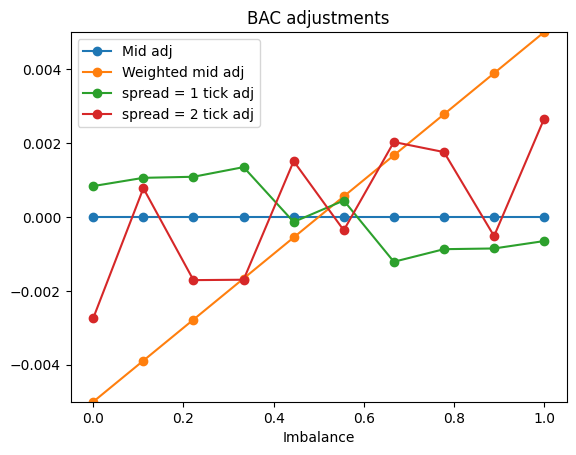

In [106]:
imb=np.linspace(0,1,n_imb)
G1,B,Q,Q2,R1,R2,K=estimate(T)
G6=plot_Gstar(ticker,G1,B,T)

In [107]:
G6

array([ 0.00083474,  0.00105762,  0.00108633,  0.00134723, -0.00013677,
        0.00044403, -0.00121349, -0.00087277, -0.00085356, -0.00065283,
       -0.00273681,  0.00077605, -0.00171007, -0.0016992 ,  0.00150873,
       -0.00036174,  0.00202695,  0.00175469, -0.00051792,  0.00265912])

Text(0.5, 0, 'Imbalance')

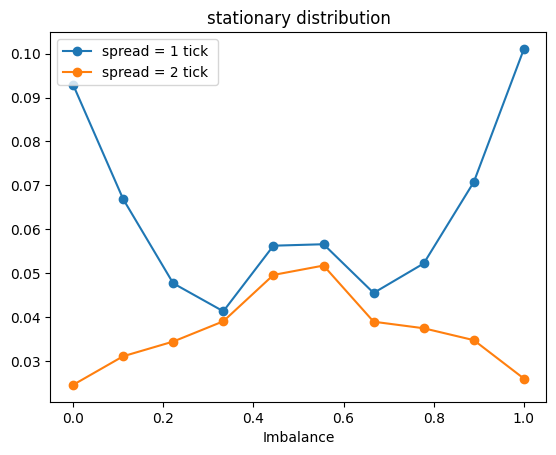

In [108]:
W=np.linalg.matrix_power(B,100)
for i in range(0,n_spread):
    plt.plot(imb,W[0][(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1)+" tick ",marker='o')
    
plt.legend(loc='upper left')
plt.title('stationary distribution')
plt.xlabel('Imbalance')

In [110]:
G.sum()

NameError: name 'G' is not defined